In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import glob
import seaborn as sns
import re
from sklearn.manifold import TSNE
from sklearn import decomposition
from collections import defaultdict
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
import gzip
import ujson as json
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import dill
from numpy import argsort
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Phrases

In [3]:
df_rev=pd.read_csv("All_Reviews.csv")
df_rest=pd.read_csv("All_Ind_Rest_SC4.csv")

In [4]:
df_rev.head()

,Unnamed: 0,author,date,friendcnt,rating,revcnt,review,userid,rest_name
0,0,Pratyusha R.,2018-07-17,137,4.0,72,new find. i stumbled across this place on yelp...,YLDbCNAQVnUS39dUixTM2g,bombay-chaat-sunnyvale-2
1,1,Dhwani P.,2018-07-11,174,3.0,2,"ordered a bunch of things here: sev puri, bhel...",hDz1BxLSVdXyXQi_AaLGGg,bombay-chaat-sunnyvale-2
2,2,Mits P.,2018-07-09,0,3.0,22,went there last evening and ordered couple of ...,-NLkCPitW9i28iH43FJ-Qg,bombay-chaat-sunnyvale-2
3,3,Bhawna J.,2018-07-29,160,5.0,107,there food is fantastic. they recently opened ...,L1yw10WZ3ylFdLxCQt3nbw,bombay-chaat-sunnyvale-2
4,4,Cherylynn N.,2018-07-05,4882,5.0,2123,it was only a couple of years ago that i disco...,eKUGKQRE-Ywi5dY55_zChg,bombay-chaat-sunnyvale-2


In [6]:
restaurant_reviews=list(df_rev.review.values)

In [7]:

#Cleaning data - remove punctuation from every review text
texts=restaurant_reviews
sentences = []
#Remove "\n" occurring in the middle of the corpus.
sentences = [re.sub(pattern=r'\n', 
                    repl='', 
                    string=x
                   ) for x in texts]
#Remove other punctuations occurring in the corpus and tokenize (split into words) the sentences
sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                    repl='', 
                    string=x
                   ).lower().strip().split(' ') for x in sentences]
#Remove occurence of '' in the token list
for x in sentences:
    while True:
        try:
            x.remove('')  # remove first occurence of ''
        except ValueError:
            break #  no more occurence of '' in the list
texts = sentences

In [8]:
len(texts)

73676

In [9]:
bifood_transformer = Phrases(texts, min_count=3,threshold=1,common_terms=STOP_WORDS)

In [10]:
bifood_texts=list(bifood_transformer[texts])

/usr/local/lib/python2.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
bifood_model = Word2Vec(bifood_texts, min_count=5, sg=1, window=5)

In [12]:
bifood_model.wv.most_similar_cosmul(positive=['chaat'],topn=10)

[(u'vada_pav', 0.911291241645813),
 (u'pav_bhaji', 0.9004287123680115),
 (u'pani_puri', 0.8959755897521973),
 (u'bhel_puri', 0.8900068998336792),
 (u'aloo_tikki', 0.8872109651565552),
 (u'dahi_papdi', 0.8862734436988831),
 (u'chat', 0.8853247761726379),
 (u'samosa_chaat', 0.8833917379379272),
 (u'bhel', 0.8817295432090759),
 (u'paani_puri', 0.8811039328575134)]

In [15]:
#------------------------------------------------------------------------------+
#   Code copied and modified from below mentioned source
#   Courtesy: Nathan A. Rooy
#   Simple word2vec from scratch with Python
#   https://github.com/nathanrooy/word2vec-from-scratch-with-python/blob/master/word2vec.py
#   https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/#figure-4
#
#------------------------------------------------------------------------------+

class word2vec():
    def __init__ (self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
        pass
    
    
    # GENERATE TRAINING DATA
    def generate_training_data(self, settings, corpus):

        # GENERATE WORD COUNTS
        word_counts = defaultdict(int)
        for row in corpus:
            for word in row:
                word_counts[word] += 1

        self.v_count = len(word_counts.keys())

        # GENERATE LOOKUP DICTIONARIES
        self.words_list = sorted(list(word_counts.keys()),reverse=False)
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))

        training_data = []
        # CYCLE THROUGH EACH SENTENCE IN CORPUS
        for sentence in corpus:
            sent_len = len(sentence)

            # CYCLE THROUGH EACH WORD IN SENTENCE
            for i, word in enumerate(sentence):
                
                #w_target  = sentence[i]
                w_target = self.word2onehot(sentence[i])

                # CYCLE THROUGH CONTEXT WINDOW
                w_context = []
                for j in range(i-self.window, i+self.window+1):
                    if j!=i and j<=sent_len-1 and j>=0:
                        w_context.append(self.word2onehot(sentence[j]))
                training_data.append([w_target, w_context])
        return np.array(training_data)


    # SOFTMAX ACTIVATION FUNCTION
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)


    # CONVERT WORD TO ONE HOT ENCODING
    def word2onehot(self, word):
        word_vec = [0 for i in range(0, self.v_count)]
        word_index = self.word_index[word]
        word_vec[word_index] = 1
        return word_vec


    # FORWARD PASS
    def forward_pass(self, x):
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u
                

    # BACKPROPAGATION
    def backprop(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

        # UPDATE WEIGHTS
        self.w1 = self.w1 - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        pass


    # TRAIN W2V model
    def train(self, training_data):
        # INITIALIZE WEIGHT MATRICES
        self.w1 = np.random.uniform(-0.8, 0.8, (self.v_count, self.n))     # context matrix
        self.w2 = np.random.uniform(-0.8, 0.8, (self.n, self.v_count))     # embedding matrix
        
        # CYCLE THROUGH EACH EPOCH
        for i in range(0, self.epochs):

            self.loss = 0

            # CYCLE THROUGH EACH TRAINING SAMPLE
            for w_t, w_c in training_data:

                # FORWARD PASS
                y_pred, h, u = self.forward_pass(w_t)
                
                # CALCULATE ERROR
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)

                # BACKPROPAGATION
                self.backprop(EI, h, w_t)

                # CALCULATE LOSS
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
                #self.loss += -2*np.log(len(w_c)) -np.sum([u[word.index(1)] for word in w_c]) + (len(w_c) * np.log(np.sum(np.exp(u))))
                
            print 'EPOCH:',i, 'LOSS:', self.loss
        pass


    # input a word, returns a vector (if available)
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w


    # input a vector, returns nearest word(s)
    def vec_sim(self, vec, top_n):

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(vec, v_w2)
            theta_den = np.linalg.norm(vec) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda(word, sim):sim, reverse=True)

        for word, sim in words_sorted[:top_n]:
            print word, sim
            
        pass

    # input word, returns top [n] most similar words
    def word_sim(self, word, top_n):
        
        w1_index = self.word_index[word]
        v_w1 = self.w1[w1_index]

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(v_w1, v_w2)
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda(word, sim):sim, reverse=True)

        for word, sim in words_sorted[:top_n]:
            print word, sim
            
        pass

#--- EXAMPLE RUN --------------------------------------------------------------+

settings = {}
settings['n'] = 40                   # dimension of word embeddings
settings['window_size'] = 4        # context window +/- center word
settings['min_count'] = 1           # minimum word count
settings['epochs'] = 1000           # number of training epochs
settings['neg_samp'] = 10           # number of negative words to use during training
settings['learning_rate'] = 0.01    # learning rate
np.random.seed(0)                   # set the seed for reproducibility

#corpus = [['the','quick','brown','fox','jumped','over','the','lazy','dog']]
corpus = bifood_texts[0:100]

# INITIALIZE W2V MODEL
w2v = word2vec()

# generate training data
training_data = w2v.generate_training_data(settings, corpus)

# train word2vec model
w2v.train(training_data)

#--- END ----------------------------------------------------------------------+

EPOCH: 0 LOSS: 666045.2113914215
EPOCH: 1 LOSS: 603047.2745854371
EPOCH: 2 LOSS: 571514.4444843855
EPOCH: 3 LOSS: 551082.7065133596
EPOCH: 4 LOSS: 535907.601829431
EPOCH: 5 LOSS: 524087.0738122887
EPOCH: 6 LOSS: 514694.5929083142
EPOCH: 7 LOSS: 507063.66165135085
EPOCH: 8 LOSS: 500658.43482145417
EPOCH: 9 LOSS: 495082.6717504633
EPOCH: 10 LOSS: 490051.80677421216
EPOCH: 11 LOSS: 485369.04546192405
EPOCH: 12 LOSS: 480906.9403214644
EPOCH: 13 LOSS: 476587.5928493686
EPOCH: 14 LOSS: 472365.16868732334
EPOCH: 15 LOSS: 468214.24942767125
EPOCH: 16 LOSS: 464122.48414848285
EPOCH: 17 LOSS: 460086.11371455574
EPOCH: 18 LOSS: 456107.0580143229
EPOCH: 19 LOSS: 452190.6514061015
EPOCH: 20 LOSS: 448344.04698931886
EPOCH: 21 LOSS: 444575.1482351298
EPOCH: 22 LOSS: 440891.86694044265
EPOCH: 23 LOSS: 437301.651080312
EPOCH: 24 LOSS: 433811.2518314668
EPOCH: 25 LOSS: 430426.63665181893
EPOCH: 26 LOSS: 427152.90831274196
EPOCH: 27 LOSS: 423994.1746447964
EPOCH: 28 LOSS: 420953.4260679925
EPOCH: 29 LOSS

EPOCH: 235 LOSS: 345641.34546812583
EPOCH: 236 LOSS: 345613.1356912178
EPOCH: 237 LOSS: 345585.22125708807
EPOCH: 238 LOSS: 345557.59813677764
EPOCH: 239 LOSS: 345530.2623659271
EPOCH: 240 LOSS: 345503.2100433833
EPOCH: 241 LOSS: 345476.43732983654
EPOCH: 242 LOSS: 345449.9404465025
EPOCH: 243 LOSS: 345423.7156738339
EPOCH: 244 LOSS: 345397.7593502656
EPOCH: 245 LOSS: 345372.0678710172
EPOCH: 246 LOSS: 345346.6376869046
EPOCH: 247 LOSS: 345321.4653031896
EPOCH: 248 LOSS: 345296.5472784676
EPOCH: 249 LOSS: 345271.88022359996
EPOCH: 250 LOSS: 345247.46080062364
EPOCH: 251 LOSS: 345223.285721765
EPOCH: 252 LOSS: 345199.35174840793
EPOCH: 253 LOSS: 345175.65569014807
EPOCH: 254 LOSS: 345152.19440382865
EPOCH: 255 LOSS: 345128.9647926244
EPOCH: 256 LOSS: 345105.9638051517
EPOCH: 257 LOSS: 345083.18843458034
EPOCH: 258 LOSS: 345060.63571778225
EPOCH: 259 LOSS: 345038.302734513
EPOCH: 260 LOSS: 345016.18660657434
EPOCH: 261 LOSS: 344994.2844970404
EPOCH: 262 LOSS: 344972.5936094692
EPOCH: 263

EPOCH: 467 LOSS: 342658.72843599715
EPOCH: 468 LOSS: 342651.4118406324
EPOCH: 469 LOSS: 342644.09483087313
EPOCH: 470 LOSS: 342636.77696730196
EPOCH: 471 LOSS: 342629.45781444345
EPOCH: 472 LOSS: 342622.1369410797
EPOCH: 473 LOSS: 342614.81392055214
EPOCH: 474 LOSS: 342607.48833111464
EPOCH: 475 LOSS: 342600.15975627146
EPOCH: 476 LOSS: 342592.8277851505
EPOCH: 477 LOSS: 342585.4920128884
EPOCH: 478 LOSS: 342578.15204102336
EPOCH: 479 LOSS: 342570.8074779069
EPOCH: 480 LOSS: 342563.4579391083
EPOCH: 481 LOSS: 342556.1030478529
EPOCH: 482 LOSS: 342548.74243542214
EPOCH: 483 LOSS: 342541.3757415924
EPOCH: 484 LOSS: 342534.0026150416
EPOCH: 485 LOSS: 342526.62271374906
EPOCH: 486 LOSS: 342519.2357053962
EPOCH: 487 LOSS: 342511.8412677376
EPOCH: 488 LOSS: 342504.43908895185
EPOCH: 489 LOSS: 342497.02886797907
EPOCH: 490 LOSS: 342489.61031482567
EPOCH: 491 LOSS: 342482.1831508342
EPOCH: 492 LOSS: 342474.74710895115
EPOCH: 493 LOSS: 342467.30193392915
EPOCH: 494 LOSS: 342459.84738253185
EPOC

EPOCH: 699 LOSS: 341071.2913061516
EPOCH: 700 LOSS: 341067.692905172
EPOCH: 701 LOSS: 341064.13832068094
EPOCH: 702 LOSS: 341060.6274800329
EPOCH: 703 LOSS: 341057.16030397895
EPOCH: 704 LOSS: 341053.7367065062
EPOCH: 705 LOSS: 341050.3565947029
EPOCH: 706 LOSS: 341047.01986859343
EPOCH: 707 LOSS: 341043.7264209907
EPOCH: 708 LOSS: 341040.47613734356
EPOCH: 709 LOSS: 341037.2688956019
EPOCH: 710 LOSS: 341034.10456606536
EPOCH: 711 LOSS: 341030.98301125853
EPOCH: 712 LOSS: 341027.9040858105
EPOCH: 713 LOSS: 341024.8676363356
EPOCH: 714 LOSS: 341021.87350133585
EPOCH: 715 LOSS: 341018.92151110864
EPOCH: 716 LOSS: 341016.0114876646
EPOCH: 717 LOSS: 341013.14324467274
EPOCH: 718 LOSS: 341010.3165873774
EPOCH: 719 LOSS: 341007.5313125822
EPOCH: 720 LOSS: 341004.7872085953
EPOCH: 721 LOSS: 341002.0840552054
EPOCH: 722 LOSS: 340999.42162366107
EPOCH: 723 LOSS: 340996.7996766604
EPOCH: 724 LOSS: 340994.21796833636
EPOCH: 725 LOSS: 340991.67624424474
EPOCH: 726 LOSS: 340989.17424137343
EPOCH: 7

EPOCH: 931 LOSS: 340845.194540634
EPOCH: 932 LOSS: 340844.5484351574
EPOCH: 933 LOSS: 340843.887711476
EPOCH: 934 LOSS: 340843.2121045253
EPOCH: 935 LOSS: 340842.52134860656
EPOCH: 936 LOSS: 340841.8151779312
EPOCH: 937 LOSS: 340841.09332716244
EPOCH: 938 LOSS: 340840.35553198674
EPOCH: 939 LOSS: 340839.60152968165
EPOCH: 940 LOSS: 340838.83105964126
EPOCH: 941 LOSS: 340838.04386390856
EPOCH: 942 LOSS: 340837.239687627
EPOCH: 943 LOSS: 340836.4182794685
EPOCH: 944 LOSS: 340835.5793919788
EPOCH: 945 LOSS: 340834.7227818734
EPOCH: 946 LOSS: 340833.84821024176
EPOCH: 947 LOSS: 340832.9554427038
EPOCH: 948 LOSS: 340832.04424948024
EPOCH: 949 LOSS: 340831.11440540996
EPOCH: 950 LOSS: 340830.1656899025
EPOCH: 951 LOSS: 340829.1978868352
EPOCH: 952 LOSS: 340828.2107844159
EPOCH: 953 LOSS: 340827.2041750027
EPOCH: 954 LOSS: 340826.177854912
EPOCH: 955 LOSS: 340825.1316241863
EPOCH: 956 LOSS: 340824.06528637436
EPOCH: 957 LOSS: 340822.9786482937
EPOCH: 958 LOSS: 340821.8715198176
EPOCH: 959 LOS

In [16]:
w2v.word_sim('dosa',10)

dosa 1.0000000000000002
butter_masala 0.6287124494112766
awful 0.6053626669445381
unfolded 0.5938203817729484
combocone 0.5690713661811629
usual 0.5588337860792784
blended 0.5494228553889634
masalah 0.5457319228240635
parotas 0.5453844348657334
dosaplain 0.5449695305621123


In [17]:
w2v.word_sim('idli',10)

idli 0.9999999999999999
best_dosa 0.697604465784632
thali_plate 0.5901652478062142
tandoori 0.5605909393709848
recommendationseverything 0.5410483786962905
he 0.5314532101512486
frugal 0.5268077757231378
somewhere 0.5244702772211618
quail 0.5146071595212908
main_course 0.5095393125699627


In [9]:
#np.save(open('word_embeddings_w2v_naive_copy4_40embed_1Kruns.npy', 'wb'),w2v.w1)

In [10]:
#np.save(open('word_vocab_w2v_naive_copy4.npy', 'wb'),w2v.word_index)

In [13]:
embeddings_40_1k = np.load(open('word_embeddings_w2v_naive_copy4_40embed_1Kruns.npy', 'rb'))

In [14]:
word2id = np.load(open('word_vocab_w2v_naive_copy4.npy', 'rb'))

## Visualizing the word embedding's

In [15]:
def tsne_plot_kmeans_elbow_detection_plot(embed,vocab):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word,indx in vocab:
        if word not in STOP_WORDS:
            tokens.append(embed[indx])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(5, 5)) 
    inertia = []
    max_k=20
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=1).fit(new_values)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(range(1, max_k), inertia, marker='s')
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$')



In [18]:
word2id_dict=word2id.tolist()

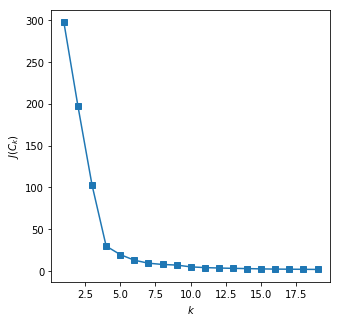

In [81]:
tsne_plot_kmeans_elbow_detection_plot(embeddings_40_1k,list(word2id_dict.items()))

In [17]:
labels = []
tokens = []

for word,indx in list(word2id_dict.items())[0:1000]:
    if word not in STOP_WORDS:
        tokens.append(embeddings_40_1k[indx])
        labels.append(word)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [82]:
kmeans = KMeans(n_clusters=4, random_state=111)
kmeans.fit(new_values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

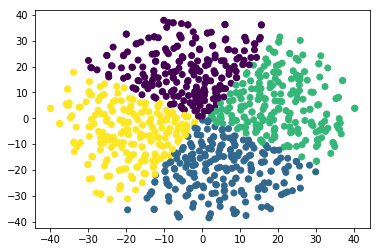

In [83]:
plt.figure('K-means with 4 clusters')
plt.scatter(new_values[:, 0], new_values[:, 1], c=kmeans.labels_)
plt.show()

In [99]:
def tsne_plot_w_clustering(embed,vocab):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    customPalette = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

    for word,indx in vocab:
        if word not in STOP_WORDS:
            tokens.append(embed[indx])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    kmeans = KMeans(n_clusters=4, random_state=111)
    kmeans.fit(new_values)
    

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color=customPalette[kmeans.labels_[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     color=customPalette[kmeans.labels_[i]])
    #plt.scatter(x,y,c=kmeans.labels_)
    plt.savefig('tsne.png', format='png', dpi=600)    
    plt.show()
    #return (labels,x,y)

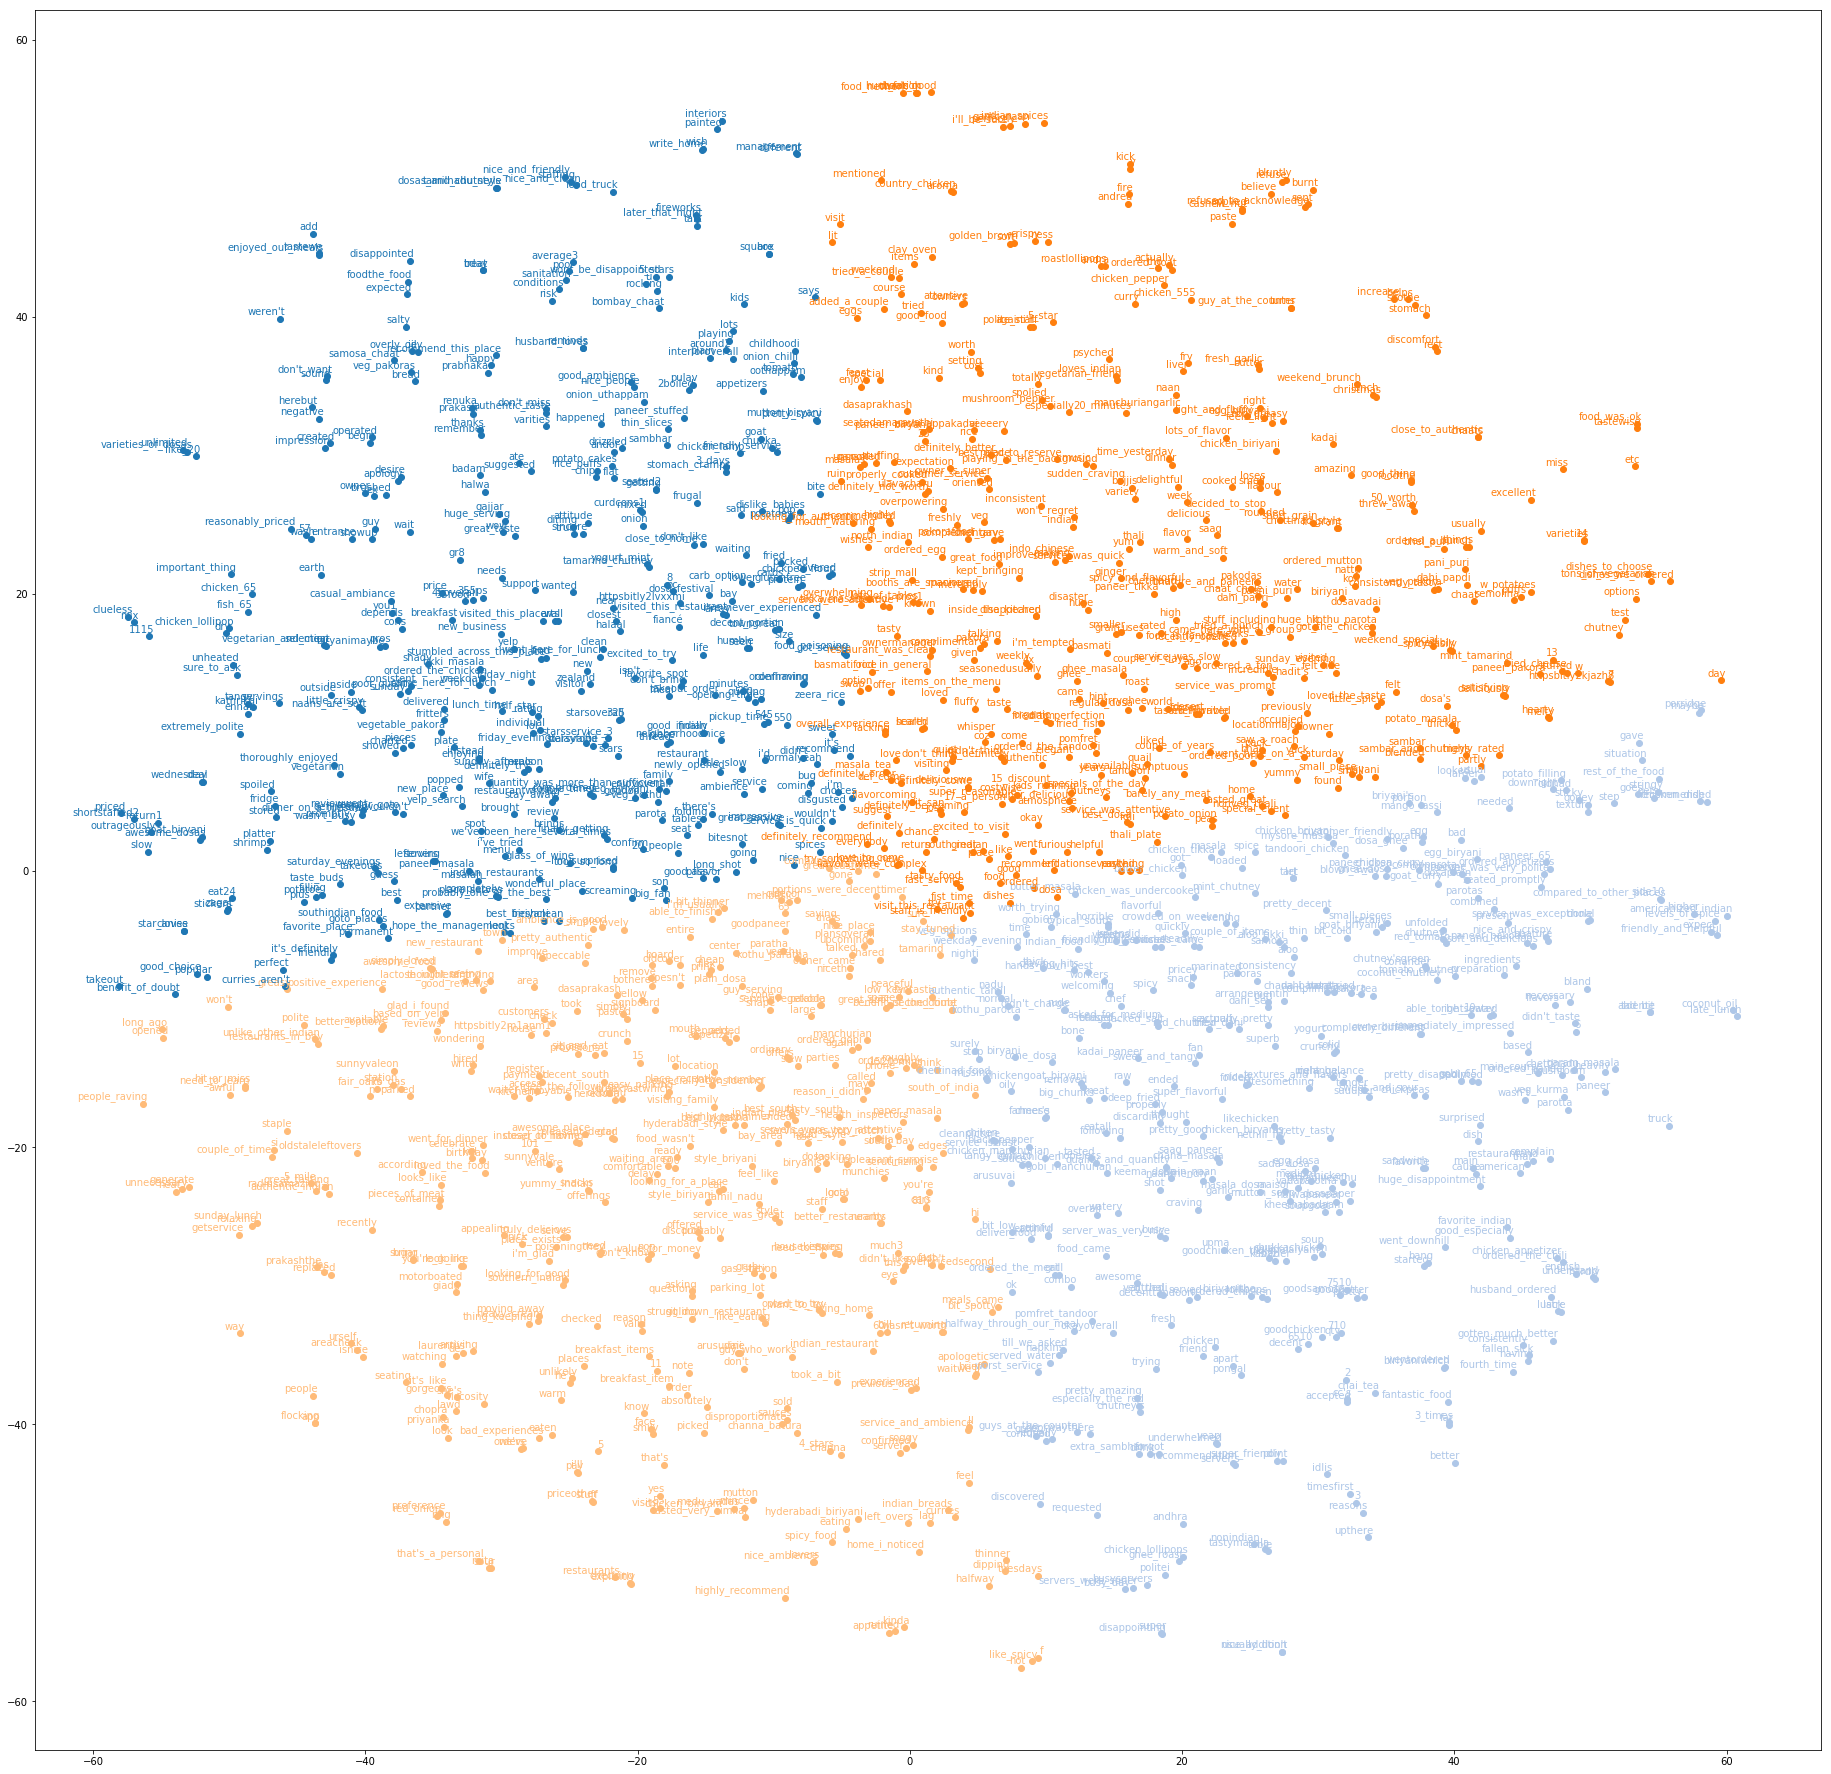

In [100]:
tsne_plot_w_clustering(embeddings_40_1k,list(word2id_dict.items()))